In [2]:
# !pip3 install gensim
# !pip3 install farm-haystack[faiss]

In [3]:
import random
import os
import numpy as np
import json
import matplotlib.pyplot as plt

import glob

import re
from nltk.tokenize import word_tokenize
import spacy

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from gensim import matutils

from sklearn.metrics.pairwise import cosine_similarity

# from haystack.document_stores import FAISSDocumentStore
# from haystack.nodes import DensePassageRetriever

from transformers import DPRContextEncoder, DPRContextEncoderTokenizer, DPRQuestionEncoder, DPRQuestionEncoderTokenizer
import torch
from tqdm import tqdm as tqdm

# Task 1 - Word2Vec

## Using gensim

In [4]:
def remove_characters(text: str) -> str:
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def get_text_files(path: str, N=0, shuffle=False) -> list:
    text_files = glob.glob(f"{path}/*.txt")
    if shuffle:
        random.shuffle(text_files)
    if N == 0:
        N = len(text_files)
    text_files = text_files[:N]
    return text_files

def get_text(text_files: list) -> list:
    text = []
    for text_file in text_files:
        with open(text_file, 'r', errors='ignore') as f:
            # content = remove_characters(f.read())
            # content = content.lower()
            content = " ".join(simple_preprocess(f.read()))
            text.append(content)
    return text

def tokenization(text):
    if type(text) == list:
        return [word_tokenize(t) for t in text]
    elif type(text) == str:
        return word_tokenize(text)
    return None

### Get text from corpus and pre-process to get list of words for each document

In [5]:
directory = "./nasa"
text_files = get_text_files(directory, shuffle=False)
text_file_names = [text_file.split('/')[-1] for text_file in text_files]
text = get_text(text_files)
tokenized_text = [simple_preprocess(sentence) for sentence in text]
print(f"Preprocessed text: \n{tokenized_text}")

Preprocessed text: 
[['miniature', 'electronic', 'temperature', 'controller', 'miniature', 'electronic', 'temperature', 'controller', 'was', 'developed', 'at', 'nasa', 'langley', 'research', 'center', 'to', 'provide', 'constant', 'temperature', 'environment', 'for', 'transducers', 'and', 'electronics', 'in', 'the', 'flaps', 'and', 'slats', 'of', 'boeing', 'aircraft', 'new', 'packaging', 'technology', 'has', 'allowed', 'nasa', 'langley', 'to', 'build', 'miniature', 'controller', 'that', 'can', 'be', 'mounted', 'almost', 'anywhere', 'the', 'controller', 'also', 'provides', 'temperature', 'monitor', 'signal', 'allowing', 'the', 'user', 'to', 'verify', 'the', 'equipment', 'is', 'controlled', 'at', 'the', 'selected', 'temperature', 'miniature', 'electronic', 'temperature', 'controller', 'controller', 'installed', 'on', 'pressure', 'array', 'system', 'potential', 'commercial', 'uses', 'temperature', 'sensitive', 'electronics', 'and', 'transducers', 'limited', 'volume', 'applications', 'aviat

### Train Word2Vec model

In [6]:
model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec_model.model")
model = Word2Vec.load("word2vec_model.model")

In [7]:
# Get vector for a word
vector = model.wv['temperature']

# Get most similar words
similar_words = model.wv.most_similar('temperature')
print(f"Similar words to temperature: \n{similar_words}")

Similar words to temperature: 
[('high', 0.9992300868034363), ('speed', 0.9992146492004395), ('such', 0.9987956285476685), ('well', 0.9986773729324341), ('control', 0.9985252022743225), ('as', 0.9984971284866333), ('digital', 0.998291552066803), ('management', 0.9982572793960571), ('molded', 0.9981471300125122), ('vibration', 0.998132586479187)]


### Generate query and document vectors, rank by cosine similarity

In [8]:
def get_query(tokenized_queries: list, N: int):
    rel_docs = []
    query = []
    for _ in range(N):
        idx = random.randint(0, len(tokenized_queries)-1)
        while (idx in rel_docs):
            idx = random.randint(0, len(tokenized_queries)-1)
        query += tokenized_queries[idx]
        rel_docs.append(idx)
    return query, rel_docs

def get_vector(words, model):
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if not word_vectors:
        return None
    return matutils.unitvec(np.mean(word_vectors, axis=0))

def test_model(query: list, rel_docs: list, N: int):
    # Get vectors for sample queries and documents
    rel_doc_names = [text_file_names[i] for i in rel_docs]
    rel_doc_content = [tokenized_text[i] for i in rel_docs]

    non_rel_docs = [i for i in range(len(tokenized_text)) if i not in rel_docs]
    non_rel_doc_names = [text_file_names[i] for i in non_rel_docs]
    non_rel_doc_content = [tokenized_text[i] for i in non_rel_docs]

    print(f"Query: \n{query}\n")
    # print(f"Relevant documents:")
    # for i in range(N):
    #     print(f"Document {i+1} ({rel_doc_names[i]}): \n{rel_doc_content[i]}\n")

    query_vector = get_vector(query, model)
    document_vectors = np.array([get_vector(doc, model) for doc in tokenized_text])

    # Compute cosine similarity and retrieve top N documents
    similarities = cosine_similarity(np.array([query_vector]), document_vectors)

    # Rank documents based on cosine similarity
    ranked_list = similarities.argsort()[0][::-1]

    # Retrieve top N documents and their names
    top_similar_docs_indices = ranked_list[:N]

    print("Top N Ranked Documents:")
    for i, idx in enumerate(top_similar_docs_indices):
        document_name = text_file_names[idx]
        print(f"Rank {i+1} --> Similarity: {similarities[0][idx]}, Document: {document_name}")

    # Retrieve ranks of relevant documents
    rel_ranks = [(i+1, text_file_names[idx]) for i, idx in enumerate(ranked_list) if idx in rel_docs]

    print("\nRanks of Relevant Documents:")
    for rank, document_name in rel_ranks:
        print(f"Rank {rank} --> Document: {document_name}")

    return query, rel_ranks

In [9]:
# Get text from key files to get sample queries
key_files = [re.sub(r'\.txt', '.key', text_file) for text_file in text_files]
key_file_text = get_text(key_files)
tokenized_queries = [simple_preprocess(sentence) for sentence in key_file_text]
print(f"Pre processed key files: \n{tokenized_queries}")

Pre processed key files: 
[['temperature', 'controller', 'transducers', 'surface', 'mounted', 'components', 'set', 'point', 'resistance', 'temperature', 'detector', 'rtd'], ['modal', 'analysis', 'control', 'design', 'eigensystem', 'realization', 'algorithm', 'era', 'vibration', 'analysis', 'structural', 'test', 'software'], ['digital', 'signal', 'processing', 'dsp', 'convolution', 'fir', 'filter', 'filtering', 'nde', 'parallel', 'processing', 'ultrasonic', 'radar'], ['internet', 'world', 'wide', 'web', 'distributed', 'information', 'systems', 'langley', 'software', 'server', 'project', 'management', 'nasa', 'technical', 'reports', 'server', 'data', 'archiving', 'technology', 'marketing'], ['computational', 'fluid', 'dynamics', 'unstructured', 'technology', 'finite', 'rate', 'chemistry', 'incompressible', 'flow', 'compressible', 'flow', 'grid', 'generation'], ['compass', 'magnetometer', 'heading', 'reference'], ['cfd', 'fluid', 'flow', 'rarefied', 'gas', 'low', 'density', 'fluids'], ['a

In [10]:
# Generate sample test queries
N = 2
test_queries = []
for _ in range(5):
    query, rel_docs = get_query(tokenized_queries, N)
    test_queries.append((query, rel_docs))

In [11]:
# Test model on queries
p = 20
res1 = {}
for i, (query, rel_docs) in enumerate(test_queries):
    q, r = test_model(query, rel_docs, p)
    res1["query" + str(i)] = {"Query": q, "Relevant doc ranks": r}
    print("\n\n")

Query: 
['high', 'temperature', 'strain', 'gage', 'compensated', 'half', 'bridge', 'positrons', 'thin', 'films', 'polymer']

Top N Ranked Documents:
Rank 1 --> Similarity: 0.9770020842552185, Document: sbr12195.txt
Rank 2 --> Similarity: 0.9761637449264526, Document: emt10695.txt
Rank 3 --> Similarity: 0.975709080696106, Document: mat06395.txt
Rank 4 --> Similarity: 0.9751793146133423, Document: sbr06195.txt
Rank 5 --> Similarity: 0.9735485315322876, Document: sbr01395.txt
Rank 6 --> Similarity: 0.9731741547584534, Document: sbr06295.txt
Rank 7 --> Similarity: 0.9711909294128418, Document: sbr18995.txt
Rank 8 --> Similarity: 0.9706106185913086, Document: sbr17695.txt
Rank 9 --> Similarity: 0.9705518484115601, Document: sbr17995.txt
Rank 10 --> Similarity: 0.969961404800415, Document: ins20495.txt
Rank 11 --> Similarity: 0.9697425365447998, Document: emt15895.txt
Rank 12 --> Similarity: 0.9696163535118103, Document: sbr17895.txt
Rank 13 --> Similarity: 0.9695996642112732, Document: sbr1

## Using spacy

In [12]:
# Load spaCy with pre-trained GloVe embeddings
nlp = spacy.load("en_core_web_sm")  # You can also use other spaCy models with different embeddings

In [13]:
# Get vectors for query and documents using spaCy
def get_spacy_vector(text):
    return nlp(text).vector

def test_glove_model(query: list, rel_docs: list, N: int):
    rel_doc_names = [text_file_names[i] for i in rel_docs]
    rel_doc_content = [tokenized_text[i] for i in rel_docs]

    non_rel_docs = [i for i in range(len(tokenized_text)) if i not in rel_docs]
    non_rel_doc_names = [text_file_names[i] for i in non_rel_docs]
    non_rel_doc_content = [tokenized_text[i] for i in non_rel_docs]

    print(f"Query: \n{query}\n")
    # print(f"Relevant documents:")
    # for i in range(N):
    #     print(f"Document {i+1} ({rel_doc_names[i]}): \n{rel_doc_content[i]}\n")

    query_vector = get_spacy_vector(" ".join(query))
    document_vectors = np.array([get_spacy_vector(" ".join(doc)) for doc in tokenized_text])

    # Compute cosine similarity and retrieve top N documents
    similarities = cosine_similarity(np.array([query_vector]), document_vectors)

    # Rank documents based on cosine similarity
    ranked_list = similarities.argsort()[0][::-1]

    # Retrieve top N documents and their names
    top_similar_docs_indices = ranked_list[:N]

    print("Top N Ranked Documents:")
    for i, idx in enumerate(top_similar_docs_indices):
        document_name = text_file_names[idx]
        print(f"Rank {i+1} --> Similarity: {similarities[0][idx]}, Document: {document_name}")

    # Retrieve ranks of relevant documents
    rel_ranks = [(i+1, text_file_names[idx]) for i, idx in enumerate(ranked_list) if idx in rel_docs]
            
    print("\nRanks of Relevant Documents:")
    for rank, document_name in rel_ranks:
        print(f"Rank {rank} --> Document: {document_name}")

    return query, rel_ranks

In [14]:
# Test model on queries
p = 20
res2 = {}
for i, (query, rel_docs) in enumerate(test_queries):
    q, r = test_glove_model(query, rel_docs, p)
    res2["query" + str(i)] = {"Query": q, "Relevant doc ranks": r}
    print("\n\n")

Query: 
['high', 'temperature', 'strain', 'gage', 'compensated', 'half', 'bridge', 'positrons', 'thin', 'films', 'polymer']

Top N Ranked Documents:
Rank 1 --> Similarity: 0.8172459602355957, Document: sbr06195.txt
Rank 2 --> Similarity: 0.8167026042938232, Document: emt20895.txt
Rank 3 --> Similarity: 0.8071312308311462, Document: mat02095.txt
Rank 4 --> Similarity: 0.7986823320388794, Document: sbr01395.txt
Rank 5 --> Similarity: 0.7965785264968872, Document: sbr15695.txt
Rank 6 --> Similarity: 0.7956219911575317, Document: sbr18095.txt
Rank 7 --> Similarity: 0.7877782583236694, Document: inf12495.txt
Rank 8 --> Similarity: 0.7814698219299316, Document: ins16895.txt
Rank 9 --> Similarity: 0.7745577096939087, Document: mat02395.txt
Rank 10 --> Similarity: 0.7737250328063965, Document: mat06395.txt
Rank 11 --> Similarity: 0.7710778713226318, Document: eos16095.txt
Rank 12 --> Similarity: 0.7642875909805298, Document: sbr21495.txt
Rank 13 --> Similarity: 0.7633261680603027, Document: eo

## Comparison

In [15]:
comparison = {}
for i in range(len(test_queries)):
    key = "query" + str(i)
    dict1 = {}
    for l in res1[key]["Relevant doc ranks"]:
        dict1[l[1]] = l[0]
    dict2 = {}
    for l in res2[key]["Relevant doc ranks"]:
        dict2[l[1]] = l[0]
    comparison[key] = {
        "Query": test_queries[i][0], 
        "Relevant docs": [text_file_names[i] for i in test_queries[i][1]],
        "Word2Vec": dict1,
        "Spacy": dict2
    }
comparison_string = json.dumps(comparison, indent=4)
print(comparison_string)

{
    "query0": {
        "Query": [
            "high",
            "temperature",
            "strain",
            "gage",
            "compensated",
            "half",
            "bridge",
            "positrons",
            "thin",
            "films",
            "polymer"
        ],
        "Relevant docs": [
            "eos19895.txt",
            "ins09595.txt"
        ],
        "Word2Vec": {
            "eos19895.txt": 35,
            "ins09595.txt": 131
        },
        "Spacy": {
            "eos19895.txt": 53,
            "ins09595.txt": 65
        }
    },
    "query1": {
        "Query": [
            "cloud",
            "detection",
            "satellite",
            "imagery",
            "remote",
            "sensing",
            "cloud",
            "masking",
            "compass",
            "magnetometer",
            "heading",
            "reference"
        ],
        "Relevant docs": [
            "inf11495.txt",
            "ins04195.txt"
        

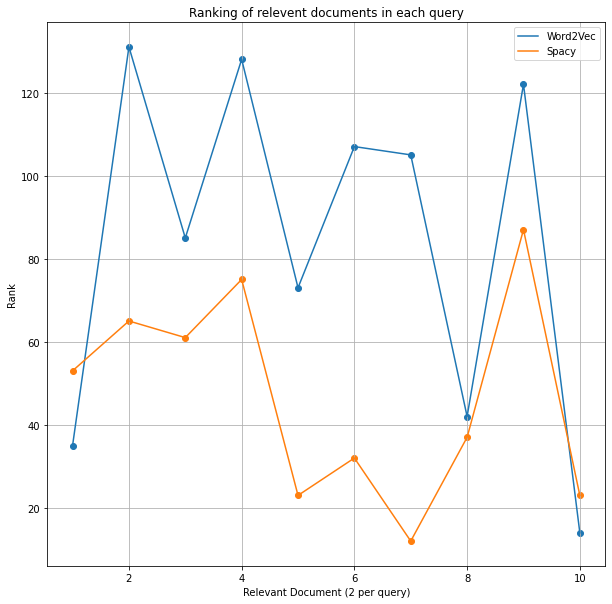

In [16]:
word2vec_ranks = []
spacy_ranks = []
for i in range(len(test_queries)):
    key = "query" + str(i)
    for doc in comparison[key]["Relevant docs"]:
        word2vec_ranks.append(comparison[key]["Word2Vec"][doc])
        spacy_ranks.append(comparison[key]["Spacy"][doc])

x = list(range(1, len(word2vec_ranks)+1))
plt.figure(figsize=(10, 10))
plt.plot(x, word2vec_ranks, label="Word2Vec")
plt.scatter(x, word2vec_ranks)
plt.plot(x, spacy_ranks, label="Spacy")
plt.scatter(x, spacy_ranks)
plt.xlabel(f"Relevant Document ({N} per query)")
plt.ylabel("Rank")
plt.title("Ranking of relevent documents in each query")
plt.grid()
plt.legend()
plt.show()

# Task 2 - DPR

In [17]:
queries = []
for i in range(len(test_queries)):
    key = f"query{i}"
    q = " ".join(comparison[key]["Query"])
    queries.append(q)
print(queries)

['high temperature strain gage compensated half bridge positrons thin films polymer', 'cloud detection satellite imagery remote sensing cloud masking compass magnetometer heading reference', 'human factors testing physiology display interface stresses cracks boundary elements', 'doppler global velocimetry dgv laser velocimetry computational cem hybrid techniques conformal antennas', 'content addressable memory cam associative memory asic energy conversion pulse detonation synthesis materials synthesis pulse detonation engine thermal coating technology waste disposal']


In [18]:
# Encode queries
question_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
question_encoder_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

encoded_queries = question_encoder_tokenizer(queries, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    queries_embeddings = question_encoder(**encoded_queries).pooler_output

print("Queries embeddings shape:", queries_embeddings.shape)

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Queries embeddings shape: torch.Size([5, 768])


In [19]:
# Load the pretrained DPR context encoder and tokenizer
context_encoder_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
context_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")

documents = get_text(text_files)

# Encode documents
encoded_documents = context_encoder_tokenizer(documents, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    documents_embeddings = context_encoder(**encoded_documents).pooler_output

print("Documents embeddings shape:", documents_embeddings.shape)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.
Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod

Documents embeddings shape: torch.Size([141, 768])


In [20]:
# Calculate similarity scores for all documents for first query
similarity_scores = [cosine_similarity(queries_embeddings[0].reshape(1, -1), doc_embedding.reshape(1, -1)).item() for doc_embedding in documents_embeddings]
similarity_scores = np.argsort(np.array(similarity_scores))[::-1]

# Rank documents based on similarity scores
ranked_documents = [text_file_names[idx] for idx in similarity_scores]
print("Ranked Documents:", ranked_documents)

Ranked Documents: ['eos19895.txt', 'str02595.txt', 'inf11495.txt', 'ins21195.txt', 'sbr06195.txt', 'emt05095.txt', 'emt07895.txt', 'mat18195.txt', 'mip14895.txt', 'ins04695.txt', 'sbr01395.txt', 'eos06895.txt', 'mat17295.txt', 'eos21295.txt', 'mip02195.txt', 'mat00695.txt', 'mat02095.txt', 'sbr06295.txt', 'eos07195.txt', 'eos06795.txt', 'ins16895.txt', 'ins13995.txt', 'ins20795.txt', 'ins05395.txt', 'mat09995.txt', 'eos06695.txt', 'eos03695.txt', 'ins20495.txt', 'mat06395.txt', 'ins14595.txt', 'ins01795.txt', 'str10895.txt', 'emt17495.txt', 'sbr01495.txt', 'mip18495.txt', 'ins15795.txt', 'emt21795.txt', 'ins16295.txt', 'eos19995.txt', 'emt04895.txt', 'ins18795.txt', 'str05695.txt', 'sbr18095.txt', 'mip19395.txt', 'sbr21395.txt', 'emt20895.txt', 'ins19295.txt', 'mip12895.txt', 'mip09195.txt', 'emt15895.txt', 'str03295.txt', 'sbr12195.txt', 'emt04995.txt', 'ins20595.txt', 'mat01095.txt', 'mip14195.txt', 'ins07595.txt', 'eos03595.txt', 'str10795.txt', 'str19495.txt', 'sbr16395.txt', 'eos1

In [21]:
# Test model on queries
p = 20
res3 = {}
for i, (query, rel_docs) in enumerate(test_queries):
    # Calculate similarity scores for all documents for first query
    similarity_scores = [cosine_similarity(queries_embeddings[i].reshape(1, -1), doc_embedding.reshape(1, -1)).item() for doc_embedding in documents_embeddings]
    similarity_scores = np.argsort(np.array(similarity_scores))[::-1]

    # Rank documents based on similarity scores
    ranked_documents = [text_file_names[idx] for idx in similarity_scores]
    print("Ranked Documents:", ranked_documents)

    rdr = [(j, ranked_documents[j]) for j in range(len(ranked_documents)) if ranked_documents[j] in comparison["query" + str(i)]["Relevant docs"]]
    rdr = {l[1]: l[0] for l in rdr}
    res3["query" + str(i)] = {"Query": query, "Relevant doc ranks": rdr}

Ranked Documents: ['eos19895.txt', 'str02595.txt', 'inf11495.txt', 'ins21195.txt', 'sbr06195.txt', 'emt05095.txt', 'emt07895.txt', 'mat18195.txt', 'mip14895.txt', 'ins04695.txt', 'sbr01395.txt', 'eos06895.txt', 'mat17295.txt', 'eos21295.txt', 'mip02195.txt', 'mat00695.txt', 'mat02095.txt', 'sbr06295.txt', 'eos07195.txt', 'eos06795.txt', 'ins16895.txt', 'ins13995.txt', 'ins20795.txt', 'ins05395.txt', 'mat09995.txt', 'eos06695.txt', 'eos03695.txt', 'ins20495.txt', 'mat06395.txt', 'ins14595.txt', 'ins01795.txt', 'str10895.txt', 'emt17495.txt', 'sbr01495.txt', 'mip18495.txt', 'ins15795.txt', 'emt21795.txt', 'ins16295.txt', 'eos19995.txt', 'emt04895.txt', 'ins18795.txt', 'str05695.txt', 'sbr18095.txt', 'mip19395.txt', 'sbr21395.txt', 'emt20895.txt', 'ins19295.txt', 'mip12895.txt', 'mip09195.txt', 'emt15895.txt', 'str03295.txt', 'sbr12195.txt', 'emt04995.txt', 'ins20595.txt', 'mat01095.txt', 'mip14195.txt', 'ins07595.txt', 'eos03595.txt', 'str10795.txt', 'str19495.txt', 'sbr16395.txt', 'eos1

In [22]:
for key in comparison:
    comparison[key]["DPR"] = res3[key]["Relevant doc ranks"]

comparison_string = json.dumps(comparison, indent=4)
print(comparison_string)

{
    "query0": {
        "Query": [
            "high",
            "temperature",
            "strain",
            "gage",
            "compensated",
            "half",
            "bridge",
            "positrons",
            "thin",
            "films",
            "polymer"
        ],
        "Relevant docs": [
            "eos19895.txt",
            "ins09595.txt"
        ],
        "Word2Vec": {
            "eos19895.txt": 35,
            "ins09595.txt": 131
        },
        "Spacy": {
            "eos19895.txt": 53,
            "ins09595.txt": 65
        },
        "DPR": {
            "eos19895.txt": 0,
            "ins09595.txt": 79
        }
    },
    "query1": {
        "Query": [
            "cloud",
            "detection",
            "satellite",
            "imagery",
            "remote",
            "sensing",
            "cloud",
            "masking",
            "compass",
            "magnetometer",
            "heading",
            "reference"
        ],


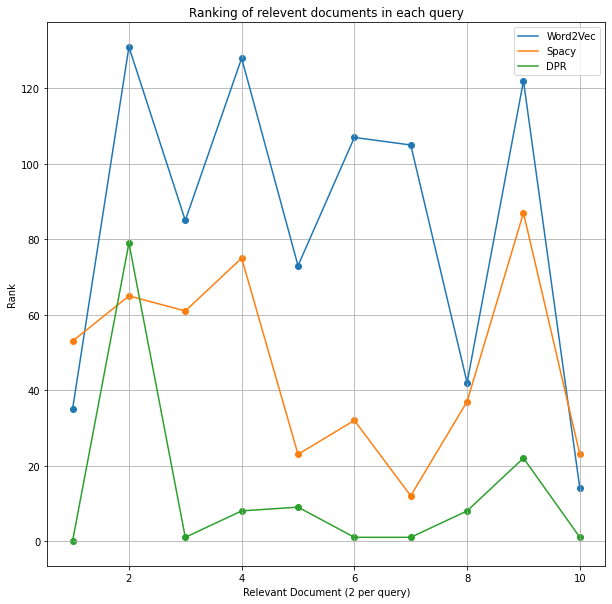

In [23]:
dpr_ranks = []
for i in range(len(test_queries)):
    key = "query" + str(i)
    for doc in comparison[key]["Relevant docs"]:
        dpr_ranks.append(comparison[key]["DPR"][doc])

x = list(range(1, len(word2vec_ranks)+1))
plt.figure(figsize=(10, 10))
plt.plot(x, word2vec_ranks, label="Word2Vec")
plt.scatter(x, word2vec_ranks)
plt.plot(x, spacy_ranks, label="Spacy")
plt.scatter(x, spacy_ranks)
plt.plot(x, dpr_ranks, label="DPR")
plt.scatter(x, dpr_ranks)
plt.xlabel(f"Relevant Document ({N} per query)")
plt.ylabel("Rank")
plt.title("Ranking of relevent documents in each query")
plt.grid()
plt.legend()
plt.show()